Based on *Using a deep temporal convolutional network as a building energy surrogate model that spans multiple climate zones*
Recreation of Westermann et al., 2020

https://doi.org/10.1016/j.apenergy.2020.115563

https://gitlab.com/energyincities/building_surrogate_modelling

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import h5py
import os

# torch.cuda.empty_cache()

Couldn't import dot_parser, loading of dot files will not be possible.


### CUDA checks

In [2]:
# print(f'PyTorch version: {torch.__version__}')
# print('*'*10)
# print(f'_CUDA version: ')
# !nvcc --version
# print('*'*10)
# print(f'CUDNN version: {torch.backends.cudnn.version()}')
# print(f'Available GPU devices: {torch.cuda.device_count()}')
# print(f'Device Name: {torch.cuda.get_device_name()}')
# print(torch.cuda.memory_summary())

In [3]:
# is_cuda_runtime =  torch.cuda.is_available()
# if not is_cuda_runtime:
#   print("Change your runtime to a GPU-accelerated one.")
# else:
#   print("All good!")
# device = "cuda" if is_cuda_runtime else "cpu"\
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.cuda.memory_allocated()

0

# Imports

In [4]:
from storage import upload_to_bucket, download_from_bucket
from schedules import mutate_timeseries
from simulate import BatchSimulator
from schema import Schema

schema = Schema()

ERROR:Schema:Failed to import a package! Be wary about continuing...
Traceback (most recent call last):
  File "c:\Users\Sam Wolk\Dropbox\mit\2023_spring\ml\ml-for-building-energy-modeling\ml-for-bem\schema.py", line 25, in <module>
    from pyumi.shoeboxer.shoebox import ShoeBox
ModuleNotFoundError: No module named 'pyumi'


In [5]:
# !pip install vapeplot &> /dev/null

In [6]:
# @markdown ### 0.4 | Styling
# import google
# import vapeplot # https://github.com/dantaki/vapeplot
import matplotlib
# is_dark = google.colab.output.eval_js(
#     'document.documentElement.matches("[theme=dark]")'
# )

matplotlib.rcParams["figure.dpi"] = 100
matplotlib.rcParams["savefig.dpi"] = 300
# load style sheet for matplotlib, a plotting library we use for 2D visualizations
plt.style.use(
    "https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle"
)
plt.style.use("dark_background")
plt.rcParams.update(
    {
        "figure.facecolor": (0.22, 0.22, 0.22, 1.0),
        "axes.facecolor": (0.22, 0.22, 0.22, 1.0),
        "savefig.facecolor": (0.22, 0.22, 0.22, 1.0),
        "grid.color": (0.4, 0.4, 0.4, 1.0),
    }
)
# vapeplot.set_palette("mallsoft")
plt.set_cmap("plasma");

<Figure size 640x480 with 0 Axes>

# Download & preprocess the data

## Weather file & schedules preprocessing

In [ ]:
# download_from_bucket(blob_name=f"climate_array.npy", file_name="./data/epws/climate_array.npy")
# download_from_bucket(blob_name=f"tsol.npy", file_name="./data/epws/tsol.npy")
# download_from_bucket(blob_name=f"default_schedules.npy", file_name="./data/template_libs/default_schedules.npy")
# download_from_bucket(blob_name=f"all_data_monthly.hdf5", file_name="./data/hdf5/all_data_monthly.hdf5")

In [7]:
climate_array = np.load("./data/epws/climate_array.npy")
tsol_array = np.load("./data/epws/tsol.npy")
tsol_array = np.load("./data/epws/tsol.npy")
schedules = np.load("./data/template_libs/default_schedules.npy") # 3x8760

[13.3 11.6 10.1 ... 16.8 16.2 14.9]


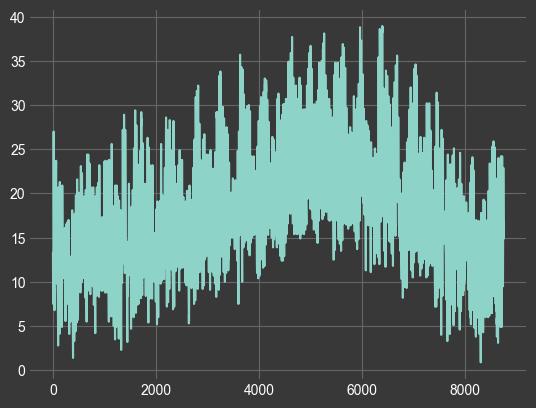

In [8]:
climate_array.shape
plt.plot(climate_array[0,0])
print(climate_array[0,0])

Make a file in data called "hdf5"

## Normalization

First, let's set up the timeseries data

In [9]:
# TODO: normalize with the batch std? or recorded
# nornalization method?
# def normalize(data, mean, std):
    # return (data-mean)/std
def normalize(data, maxv, minv):
    return (data-minv)/(maxv-minv)

In [10]:
dbt_max = 50.0 # 50.5
dbt_min = -35.0
rh_max = 100.0
rh_min = 0.0 # 2.0
atm_max = 105800.0
atm_min = 75600.0
rad_min = 0.0
ghrad_max = 1200.0 #1154.0
dnrad_max = 1097.0
dhrad_max = 689.0
skyt_max = 32.3
skyt_min = -58.3
tsol_max = 60
tsol_min = -40

In [11]:
# Normalize the whole climate and tsol array
maxes = [dbt_max, rh_max, atm_max, ghrad_max, dnrad_max, dhrad_max, skyt_max]
mins = [dbt_min, rh_min, atm_min, rad_min, rad_min, rad_min, skyt_min]

norm_climate_array = np.zeros(climate_array.shape)
norm_tsol_array = np.zeros(tsol_array.shape)
for j in range(climate_array.shape[0]):
    for i in range(7):
        norm_climate_array[j, i, :] = normalize(climate_array[j, i, :], maxes[i], mins[i])
    for i in range(4):
        norm_tsol_array[j, i, :] = normalize(tsol_array[j, i, :], tsol_max, tsol_min)

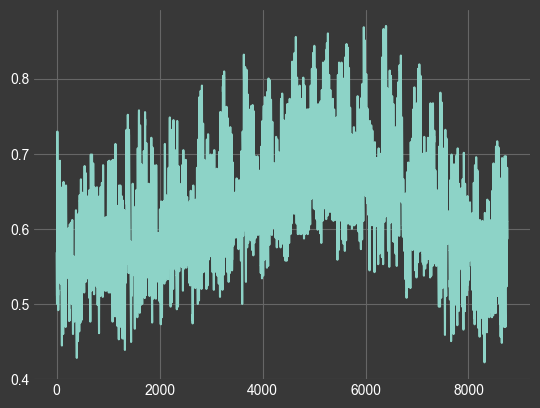

In [12]:

plt.plot(norm_climate_array[0,0])

Schedules

Now for the building vector

In [13]:
building_vect_schema = [
    'width', 
    'height', 
    'facade_2_footprint', 
    'perim_2_footprint',
    'roof_2_footprint',
    'footprint_2_ground',
    'wwr',
    'orientation',
    'HeatingSetpoint',
    'CoolingSetpoint',
    'LightingPowerDensity',
    'EquipmentPowerDensity',
    'PeopleDensity',
    'Infiltration',
    'FacadeMass',
    'RoofMass',
    'FacadeRValue',
    'RoofRValue',
    'SlabRValue',
    ]

building_vector_size = len(building_vect_schema) + 3 # (area/windowsettings)


And finally, the output energy data 

In [ ]:
# for i in range(1000):
#     plt.plot(norm_results[i, 0, :], 'orange', alpha=0.2)
#     plt.plot(norm_results[i, 1, :], 'lightblue', alpha=0.5)
# plt.plot(np.mean(norm_results[:, 0, :], axis=0), 'orangered', label="Heating")
# plt.plot(np.mean(norm_results[:, 1, :], axis=0), 'dodgerblue', label="Cooling")
# plt.legend()
# plt.show()

# Sample Loader from Dataset

In [14]:
# the loading & preprocessing grouped into a function
def load_training_samples(schema,
    start_idx = 0,
    count = 20000,
    dbt_max = 50.0, # 50.5
    dbt_min = -35.0,
    rh_max = 100.0,
    rh_min = 0.0, # 2.0
    atm_max = 105800.0,
    atm_min = 75600.0,
    rad_min = 0.0,
    ghrad_max = 1200.0, #1154.0
    dnrad_max = 1097.0,
    dhrad_max = 689.0,
    skyt_max = 32.3,
    skyt_min = -58.3,
    tsol_max = 60,
    tsol_min = -40,
    a_max = 2000,
    a_min = 0,
    energy_min = 0,
    energy_max = 30, # 30 kWh/m2/mo
):
    with h5py.File(f"./data/hdf5/all_data_monthly.hdf5", 'r') as f:
        batch_size=count
        monthly = f["monthly"][start_idx:start_idx+batch_size] # this loads the whole batch into memory!
        # total_heating = f["total_heating"][0:batch_size] # this loads the whole batch into memory!
        # total_cooling = f["total_cooling"][0:batch_size] # this loads the whole batch into memory!
        # errors = f["errors"][...]
        area = f["area"][start_idx:start_idx+batch_size]
        batch = f["storage_batch"][start_idx:start_idx+batch_size]
    # Normalize the whole climate and tsol array
    maxes = [dbt_max, rh_max, atm_max, ghrad_max, dnrad_max, dhrad_max, skyt_max]
    mins = [dbt_min, rh_min, atm_min, rad_min, rad_min, rad_min, skyt_min]

    norm_climate_array = np.zeros(climate_array.shape)
    norm_tsol_array = np.zeros(tsol_array.shape)
    for j in range(climate_array.shape[0]):
        for i in range(7):
            norm_climate_array[j, i, :] = normalize(climate_array[j, i, :], maxes[i], mins[i])
        for i in range(4):
            norm_tsol_array[j, i, :] = normalize(tsol_array[j, i, :], tsol_max, tsol_min)

    # Schedules
    seeds = schema["schedules_seed"].extract_storage_values_batch(batch).astype(int) # 1x1
    operations_maps = schema["schedules"].extract_storage_values_batch(batch) # 3

    # timeseries_vector = np.zeros((data_size, 8, 8760))
    data_size = batch.shape[0]
    timeseries_vector = np.zeros((data_size, 11, 8760))
    orientations = schema['orientation'].extract_storage_values_batch(batch).flatten()
    idxs = schema['base_epw'].extract_storage_values_batch(batch).flatten()
    # Get the weather file for each entry
    for i, epw_idx in enumerate(idxs):
        epw_idx = int(epw_idx)
        timeseries_vector[i, :-4, :] = norm_climate_array[epw_idx]
        timeseries_vector[i, -4:-1, :] = mutate_timeseries(schedules, operations_maps[i], seeds[i])
        timeseries_vector[i, -1, :] = norm_tsol_array[epw_idx, int(orientations[i]), :]
    wind_settings = schema["WindowSettings"].extract_storage_values_batch(batch)

    

    building_vector = np.zeros((data_size, 22))
    for i, schema_name in enumerate(building_vect_schema):
        column = schema[schema_name].extract_storage_values_batch(batch).flatten()
        try:
            column = normalize(column, schema[schema_name].max, schema[schema_name].min)
        except:
            print(f"Calculating mean from batch data for {schema_name}...")
            column = normalize(column, np.max(column), np.min(column))
        building_vector[:, i] = column
    building_vector[:, -3] = normalize(area, a_max, a_min)
    building_vector[:, -2] = normalize(wind_settings[:, 0].flatten(), schema["WindowSettings"].max[0], schema["WindowSettings"].min[0]) # U-val
    building_vector[:, -1] = normalize(wind_settings[:, 1].flatten(), schema["WindowSettings"].max[1], schema["WindowSettings"].min[1]) # shgc

    # Add core and perimeter together
    heating = (monthly[:, 0, :]+monthly[:, 2, :]) / area.reshape(-1,1)
    cooling = (monthly[:, 1, :]+monthly[:, 3, :]) / area.reshape(-1,1)
    area_normed_results = np.concatenate((np.expand_dims(heating, 1), np.expand_dims(cooling, 1)), axis=1)

    norm_results = normalize(area_normed_results, energy_max*2.777e7, energy_min*2.777e7)
    # TODO: MAKE THIS EUI?


    return building_vector, timeseries_vector, norm_results

# Load Part of the Dataset into Memory

Calculating mean from batch data for orientation...


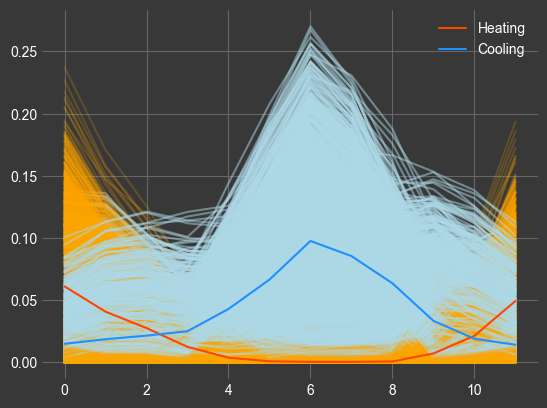

(2000, 22)


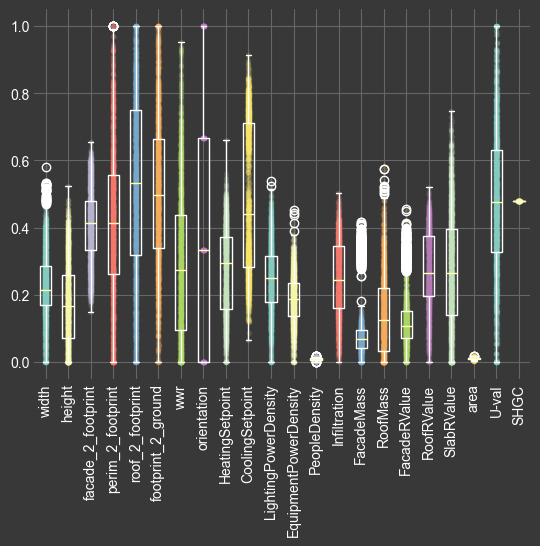

CPU times: total: 5.69 s
Wall time: 7.03 s


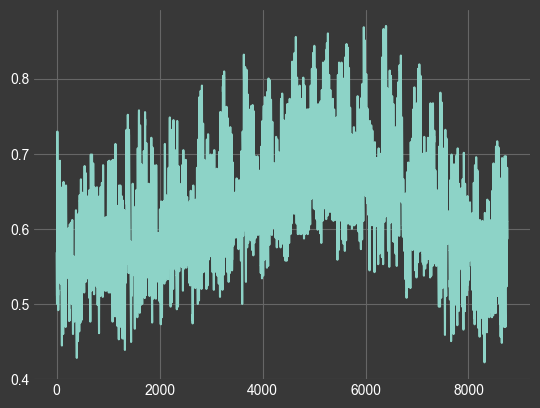

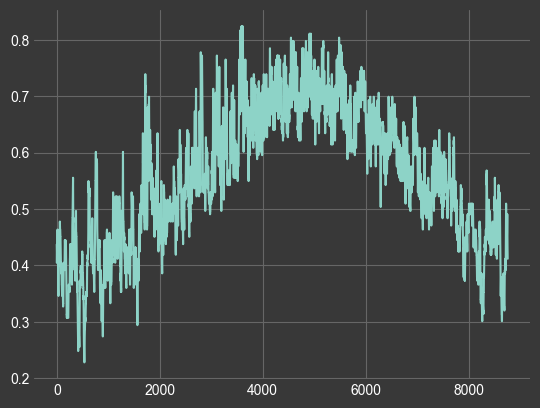

In [109]:
%%time
start_idx = 0
bldg_count = 2000

building_vector, timeseries_vector, norm_results = load_training_samples(schema, start_idx=start_idx, count=bldg_count)

for i in range(bldg_count):
    plt.plot(norm_results[i, 0, :], 'orange', alpha=0.2)
    plt.plot(norm_results[i, 1, :], 'lightblue', alpha=0.5)
plt.plot(np.mean(norm_results[:, 0, :], axis=0), 'orangered', label="Heating")
plt.plot(np.mean(norm_results[:, 1, :], axis=0), 'dodgerblue', label="Cooling")
plt.legend()
plt.show()

for c in range(len(building_vect_schema) + 3):
    y = building_vector[:, c]
    # Add some random "jitter" to the x-axis
    x = np.random.normal(c, 0.01, size=len(y))
    plt.plot(x+1, y, '.', alpha=0.1)
plt.boxplot(building_vector)
plt.xticks(ticks = list(range(1, 23)), labels=building_vect_schema + ["area", "U-val", "SHGC"], rotation = 90)
plt.show()

plt.figure()
plt.plot(timeseries_vector[0,0])

plt.figure()
plt.plot(timeseries_vector[1001,0])

# Set up the model

## Timeseries CNN

In [15]:
import torch.nn as nn
import torch.optim as optim

class EnergyTimeseriesCNNBlockA(nn.Module):
    def __init__(self, 
                 in_channels=11,
                 n_feature_maps = 64,
                 ):
        super().__init__()

        self.n_feature_maps=n_feature_maps

        self.input_convolutional_layer = nn.Sequential(
            nn.Conv1d(
                in_channels=in_channels,
                out_channels=n_feature_maps,
                kernel_size=8,
                stride=1,
                padding='same',
            ),
            nn.BatchNorm1d(n_feature_maps),
        )

        self.mid_convolutional_layer = nn.Sequential(
            nn.Conv1d(
                in_channels=n_feature_maps,
                out_channels=n_feature_maps,
                kernel_size=5,
                stride=1,
                padding='same',
            ),
            nn.BatchNorm1d(n_feature_maps),
        )

        self.final_convolutional_layer = nn.Sequential(
            nn.Conv1d(
                in_channels=n_feature_maps,
                out_channels=n_feature_maps,
                kernel_size=3,
                stride=1,
                padding='same',
            ),
            nn.BatchNorm1d(n_feature_maps),
        )

        self.skip_layer = nn.Sequential(
            nn.Conv1d(
                in_channels=in_channels,
                out_channels=n_feature_maps,
                kernel_size=1,
                stride=1,
                padding=0,
            ),
            nn.BatchNorm1d(n_feature_maps), 
        )

    def forward(self, x):
        x_skip = self.skip_layer(x)
        
        x_out = self.input_convolutional_layer(x)
        x_out = nn.functional.relu(x_out)

        x_out = self.mid_convolutional_layer(x_out)
        x_out = nn.functional.relu(x_out)

        x_out = self.final_convolutional_layer(x_out)
        
        x_out = x_out + x_skip
        
        return nn.functional.relu(x_out)

class EnergyTimeseriesCNNBlockB(nn.Module):
    def __init__(self, 
                 in_channels=128,
                 n_feature_maps = 128,
                 ):
        super().__init__()

        self.n_feature_maps=n_feature_maps

        self.input_convolutional_layer = nn.Sequential(
            nn.Conv1d(
                in_channels=in_channels,
                out_channels=n_feature_maps,
                kernel_size=8,
                stride=1,
                padding='same',
            ),
            nn.BatchNorm1d(n_feature_maps),
        )

        self.mid_convolutional_layer = nn.Sequential(
            nn.Conv1d(
                in_channels=n_feature_maps,
                out_channels=n_feature_maps,
                kernel_size=5,
                stride=1,
                padding='same',
            ),
            nn.BatchNorm1d(n_feature_maps),
        )

        self.final_convolutional_layer = nn.Sequential(
            nn.Conv1d(
                in_channels=n_feature_maps,
                out_channels=n_feature_maps,
                kernel_size=3,
                stride=1,
                padding='same',
            ),
            nn.BatchNorm1d(n_feature_maps),
        )

        self.skip_layer = nn.BatchNorm1d(n_feature_maps)

    def forward(self, x):
        x_skip = self.skip_layer(x)
        
        x_out = self.input_convolutional_layer(x)
        x_out = nn.functional.relu(x_out)

        x_out = self.mid_convolutional_layer(x_out)
        x_out = nn.functional.relu(x_out)

        x_out = self.final_convolutional_layer(x_out)
        
        x_out = x_out + x_skip
        
        return nn.functional.relu(x_out)


class AnnualEnergyCNN(nn.Module):
    def __init__(self, 
               out_channels=22,
               n_feature_maps = 64,
               ):
        super().__init__()

        self.resblock_1 = EnergyTimeseriesCNNBlockA(
            n_feature_maps=n_feature_maps
            )
        
        self.resblock_2 = EnergyTimeseriesCNNBlockA(
            in_channels=n_feature_maps,
            n_feature_maps=n_feature_maps*2
            )
        
        # no need to expand channels in third layer because they are equal
        self.resblock_3 = EnergyTimeseriesCNNBlockB(
            in_channels=n_feature_maps*2,
            n_feature_maps=n_feature_maps*2
            )
        
        # FOR ANNUAL
        self.GlobalAveragePool = nn.AvgPool1d(kernel_size=8760) # 1D? average across all feature maps
        self.linear = nn.Linear(in_features=n_feature_maps*2, out_features=out_channels)

    def forward(self, x):
        x = self.resblock_1(x)
        x = self.resblock_2(x)
        x = self.resblock_3(x)
        x = self.GlobalAveragePool(x)
        x = x.squeeze(-1)
        x = self.linear(x)
        return nn.functional.relu(x)

class MonthlyEnergyCNN(nn.Module):
    def __init__(self, 
               in_channels=8,
               out_channels=8,
               n_feature_maps = 64,
               ):
        super().__init__()

        self.resblock_1 = EnergyTimeseriesCNNBlockA(
            n_feature_maps=n_feature_maps
            )
        
        self.resblock_2 = EnergyTimeseriesCNNBlockA(
            in_channels=n_feature_maps,
            n_feature_maps=n_feature_maps*2
            )
        
        # no need to expand channels in third layer because they are equal
        self.resblock_3 = EnergyTimeseriesCNNBlockB(
            in_channels=n_feature_maps*2,
            n_feature_maps=n_feature_maps*2
            )
        
        # FOR MONTHLY (out is 2x12)
        self.month_convolutional_layer = nn.Sequential(
            nn.Conv1d(
                in_channels=n_feature_maps*2,
                out_channels=out_channels,
                kernel_size=30,
                stride=1,
                padding='same',
            ),
            nn.BatchNorm1d(out_channels),
        )   
        self.pooling = nn.AvgPool1d(kernel_size=730)

    def forward(self, x):
        x = self.resblock_1(x)
        x = self.resblock_2(x)
        x = self.resblock_3(x)
        x = self.pooling(x)
        x = self.month_convolutional_layer(x)
        return nn.functional.relu(x)

## Energy surrogate

In [16]:
class EnergyCNN(torch.nn.Module):
    def __init__(self, 
                 in_channels=30,
                 n_feature_maps=64,
                 out_channels=2
                 ):
        super(EnergyCNN, self).__init__()

        # FOR MONTHLY (out is 2x12)
        self.in_convolutional_layer = nn.Sequential(
            nn.Conv1d(
                in_channels=in_channels,
                out_channels=n_feature_maps,
                kernel_size=2,
                stride=1,
                padding='same',
            ),
            nn.BatchNorm1d(n_feature_maps),
            )
        
        self.out_convolutional_layer = nn.Sequential(
            nn.Conv1d(
                in_channels=n_feature_maps,
                out_channels=out_channels,
                kernel_size=2,
                stride=1,
                padding='same',
            ),
            nn.BatchNorm1d(out_channels),
            )  
        # self.pooling = nn.AvgPool1d(kernel_size=730)

    def forward(self, sample):
        # sample (22+n, 1)
        x = self.in_convolutional_layer(sample)
        x = nn.functional.leaky_relu(x)
        x = self.out_convolutional_layer(x)
        x = nn.functional.leaky_relu(x)

        return x

## Init Models

In [17]:
latent_size = 22
building_vector_size = len(building_vect_schema)+3
energy_input_size = latent_size + building_vector_size
timeseries_model = MonthlyEnergyCNN(out_channels=latent_size).to(device)
energy_model = EnergyCNN(in_channels=energy_input_size).to(device)

# Dataloaders

First, split the data into training, validation, and testing (80/10/10).

In [18]:
def make_dataset(start_idx, count, loader_batch_size=100):
    torch.cuda.empty_cache()
    building_vector, timeseries_vector, norm_results = load_training_samples(schema, start_idx=start_idx, count=count)
    dataset  = {}
    for i in range(building_vector.shape[0]):
        # DICT ENTRIES MUST BE IN ORDER
        dataset[i] = dict({
            "building_vector": np.array([building_vector[i]]*12).T,
            "timeseries_vector": timeseries_vector[i],
            "results_vector": norm_results[i],
        })
    generator = torch.Generator()
    generator.manual_seed(0)

    train, val, test = torch.utils.data.random_split(dataset, lengths=[0.8, 0.1, 0.1], generator=generator)
    training_dataloader = torch.utils.data.DataLoader(train, batch_size=loader_batch_size, shuffle=False)
    validation_dataloader = torch.utils.data.DataLoader(val, batch_size=loader_batch_size, shuffle=False)
    test_dataloader = torch.utils.data.DataLoader(test, batch_size=loader_batch_size, shuffle=False)
    return {"datasets": {"train": train, "test": test, "validate": val}, "dataloaders": {"train": training_dataloader, "test": test_dataloader, "validate": validation_dataloader}}



# Train the model

In [19]:
from datetime import datetime

In [ ]:
timeseries_model.train()
energy_model.train()

n_full_epochs = 3
n_mini_epochs = 3
mini_epoch_batch_size = 50000
train_test_split_idx = 400000
loader_batch_size = 200

run_name_prefix = "final_run"

learning_rate = 1e-3
step_loss_frequency = 50
training_loss_history = []
validation_loss_history  = []
withheld_loss_history = []
latentvect_history  = []

# LOSS FUNCTION
loss_function = nn.MSELoss()

# optimizer = torch.optim.Adam(energy_model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(list(timeseries_model.parameters()) + list(energy_model.parameters()), lr=learning_rate)

available_simulations = train_test_split_idx - mini_epoch_batch_size

unseen_cities = make_dataset(train_test_split_idx, count=20000, loader_batch_size=200)

for full_epoch_num in range(n_full_epochs):
    print(f"\n\n\n{'-'*20} MAJOR Epoch {full_epoch_num} {'-'*20}")
    for start_idx in range(0,available_simulations+1,mini_epoch_batch_size):
        print(f"\n{'-'*20} Epoch {'-'*20}")
        print(f"Simulations: {start_idx} to {start_idx+mini_epoch_batch_size}")
        print(f"Loading data...")
        data = make_dataset(start_idx=start_idx, count=mini_epoch_batch_size, loader_batch_size=loader_batch_size)
        training_dataloader = data["dataloaders"]["train"]
        validation_dataloader = data["dataloaders"]["validate"]

        print("Starting training...")

        for epoch_num in range(n_mini_epochs):
            print(f"{'-'*20} MiniBatch Epoch number {epoch_num} {'-'*20}")
            for j, sample in enumerate(training_dataloader):
                optimizer.zero_grad()
                
                timeseries = sample["timeseries_vector"].to(device).float()
                # timeseries[:,:7] = 0 # no weather except tsol!
                bldg_vect = sample["building_vector"].to(device).float()
                # Repeat bldg_vect for monthly size:
                loads = sample["results_vector"].to(device).float()

                timeseries_latvect = timeseries_model(timeseries)

                # Concatenate vectors
                x = torch.cat([timeseries_latvect, bldg_vect], axis=1).squeeze(1)
                # print(x.shape)

                predicted_loads = energy_model(x)

                loss = loss_function(loads, predicted_loads)

                if j%step_loss_frequency == 0:
                    print(f"Step {j} loss: {loss.item()}")
                    latentvect_history.append(timeseries_latvect.detach())
                
                training_loss_history.append([len(training_loss_history),loss.item()])

                loss.backward()
                optimizer.step()
            

            with torch.no_grad():
                epoch_validation_loss = []
                epoch_withheld_loss = []
                for sample in validation_dataloader:
                    # SET UP SAMPLE DATA
                    timeseries_val = sample["timeseries_vector"].to(device).float()
                    # timeseries_val[:,:7] = 0 # no weather except tsol!
                    # print(timeseries.shape)
                    bldg_vect_val = sample["building_vector"].to(device).float()
                    # Repeat bldg_vect for monthly size:
                    # bldg_vect_month_val = np.repeat(bldg_vect_val.unsqueeze(2), 12, axis=2)
                    loads = sample["results_vector"].to(device).float()

                    timeseries_latvect_val = timeseries_model(timeseries_val)

                    # Concatenate vectors
                    x_val = torch.cat([timeseries_latvect_val, bldg_vect_val], axis=1).squeeze(1)

                    predicted_loads = energy_model(x_val)

                    loss = loss_function(loads, predicted_loads)
                    
                    epoch_validation_loss.append(loss.item())

                mean_validation_loss = np.mean(epoch_validation_loss)
                print(f"Mean validation loss for batch: {mean_validation_loss}")

                validation_loss_history.append([len(training_loss_history), mean_validation_loss])
        # Finished repeating training on MiniBatch, check loss on fully unseen cities
        with torch.no_grad():
            for sample in unseen_cities["dataloaders"]["train"]: # using train is fine since this data is never seen
                # SET UP SAMPLE DATA
                timeseries_val = sample["timeseries_vector"].to(device).float()
                # timeseries_val[:,:7] = 0 # no weather except tsol!
                # print(timeseries.shape)
                bldg_vect_val = sample["building_vector"].to(device).float()
                # Repeat bldg_vect for monthly size:
                # bldg_vect_month_val = np.repeat(bldg_vect_val.unsqueeze(2), 12, axis=2)
                loads = sample["results_vector"].to(device).float()

                timeseries_latvect_val = timeseries_model(timeseries_val)

                # Concatenate vectors
                x_val = torch.cat([timeseries_latvect_val, bldg_vect_val], axis=1).squeeze(1)

                predicted_loads = energy_model(x_val)

                loss = loss_function(loads, predicted_loads)
                
                epoch_validation_loss.append(loss.item())
            mean_validation_loss = np.mean(epoch_validation_loss)
            print(f"Mean validation loss for withheld data: {mean_validation_loss}")

            withheld_loss_history.append([len(training_loss_history), mean_validation_loss])
        training_loss_history_array = np.array(training_loss_history)
        validation_loss_history_array = np.array(validation_loss_history)
        withheld_loss_history_array = np.array(withheld_loss_history)

        plt.figure(figsize=(6,3))
        plt.plot(training_loss_history_array[:,0],training_loss_history_array[:,1], label="Training loss")
        plt.plot(validation_loss_history_array[:,0],validation_loss_history_array[:,1], label="In-Sample Validation loss")
        plt.plot(withheld_loss_history_array[:,0],withheld_loss_history_array[:,1], lw=2, label="Out of Sample Validation loss")
        plt.ylim([0,0.001])
        plt.legend()
        plt.show()

        del training_dataloader
        del validation_dataloader
        del data
    
    timestamp = datetime.now().strftime("%Y%m%d%H%M")
    uid = 'SW'
    timeseries_path = f"./checkpoints/{timestamp}_timeseries_{uid}.pt"
    energy_path = f"./checkpoints/{timestamp}_energy_{uid}.pt"
    torch.save({
        'epoch': full_epoch_num,
        'model_state_dict': timeseries_model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss.item(),
        },
        timeseries_path
    )
    torch.save({
        'epoch': full_epoch_num,
        'model_state_dict': energy_model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss.item(),
        },
        energy_path
    )
    upload_to_bucket(f"models/{run_name_prefix}_{full_epoch_num}_timeseries_{train_test_split_idx}_sims_{n_full_epochs}_epochs_{mini_epoch_batch_size}_minibatch_{n_mini_epochs}_miniepochs_{loader_batch_size}_loaderbatch_lr{learning_rate}.pt", timeseries_path)
    upload_to_bucket(f"models/{run_name_prefix}_{full_epoch_num}_energy_{train_test_split_idx}_sims_{n_full_epochs}_epochs_{mini_epoch_batch_size}_minibatch_{n_mini_epochs}_miniepochs_{loader_batch_size}_loaderbatch_lr{learning_rate}.pt", energy_path)

In [ ]:
# Save checkpoint
from datetime import datetime

timestamp = datetime.now().strftime("%Y%m%d%H%M")
uid = 'SW'
timeseries_path = f"./checkpoints/{timestamp}_timeseries_{uid}.pt"
energy_path = f"./checkpoints/{timestamp}_energy_{uid}.pt"
torch.save({
    'epoch': epoch_num,
    'model_state_dict': timeseries_model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss.item(),
    },
    timeseries_path
)
torch.save({
    'epoch': epoch_num,
    'model_state_dict': energy_model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss.item(),
    },
    energy_path
)
upload_to_bucket(f"models/FULLWEATHER_FINAL_timeseries_{train_test_split_idx}_sims_{n_full_epochs}_epochs_{mini_epoch_batch_size}_minibatch_{n_mini_epochs}_miniepochs_{loader_batch_size}_loaderbatch_lr{learning_rate}.pt", timeseries_path)
upload_to_bucket(f"models/FULLWEATHER_FINAL_energy_{train_test_split_idx}_sims_{n_full_epochs}_epochs_{mini_epoch_batch_size}_minibatch_{n_mini_epochs}_miniepochs_{loader_batch_size}_loaderbatch_lr{learning_rate}.pt", energy_path)

In [ ]:
# do a visualization of data after each block?
bldgs_to_plot = 10
fig, ax = plt.subplots(ncols=10, nrows=1, figsize=(20,10))
for i in range(bldgs_to_plot):
    ax[i].imshow(timeseries_latvect[int(np.random.rand()*timeseries_latvect.shape[0])].detach().cpu().numpy())
    # ax[i].set_axis("off")

Plot the training and validation loss and history

In [ ]:
training_loss_history_array = np.array(training_loss_history)
validation_loss_history_array = np.array(validation_loss_history)
withheld_loss_history_array = np.array(withheld_loss_history)

plt.figure(figsize=(6,3))
plt.plot(training_loss_history_array[:,0],training_loss_history_array[:,1], label="Training loss")
plt.plot(validation_loss_history_array[:,0],validation_loss_history_array[:,1], label="In-Sample Validation loss")
plt.plot(withheld_loss_history_array[:,0],withheld_loss_history_array[:,1], lw=2, label="Out of Sample Validation loss")
plt.ylim([0,0.001])
plt.legend()
plt.show()

# Testing

In [20]:
download_from_bucket("models/FINAL-TRAINED-FULL-WEATHER-timeseries.pt", "checkpoints/timeseries-fw.pt")
download_from_bucket("models/FINAL-TRAINED-FULL-WEATHER-energy.pt", "checkpoints/energy-fw.pt")
# download_from_bucket("models/FULLWEATHER_FINAL_timeseries_400000_sims_3_epochs_50000_minibatch_3_miniepochs_200_loaderbatch_lr0.001.pt", "checkpoints/timeseries-fw.pt")
# download_from_bucket("models/FULLWEATHER_FINAL_energy_400000_sims_3_epochs_50000_minibatch_3_miniepochs_200_loaderbatch_lr0.001.pt", "checkpoints/energy-fw.pt")
timeseries_model.load_state_dict(torch.load("checkpoints/timeseries-fw.pt")["model_state_dict"])
energy_model.load_state_dict(torch.load("./checkpoints/energy-fw.pt")["model_state_dict"])


INFO:Storage:Downloading bucket:models/FINAL-TRAINED-FULL-WEATHER-timeseries.pt to file:checkpoints/timeseries-fw.pt...
INFO:Storage:Done downloading.
INFO:Storage:Downloading bucket:models/FINAL-TRAINED-FULL-WEATHER-energy.pt to file:checkpoints/energy-fw.pt...
INFO:Storage:Done downloading.


<All keys matched successfully>

In [21]:
timeseries_model.eval()
energy_model.eval()

EnergyCNN(
  (in_convolutional_layer): Sequential(
    (0): Conv1d(44, 64, kernel_size=(2,), stride=(1,), padding=same)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (out_convolutional_layer): Sequential(
    (0): Conv1d(64, 2, kernel_size=(2,), stride=(1,), padding=same)
    (1): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

In [47]:
all_loads = []
all_results = []
unseen_climates = make_dataset(start_idx=500000, count=2000)
test_dataloader = unseen_climates["dataloaders"]["test"] # fine to use training since it's never been seen
losses = []
print("starting projection")
epws = []
czs = []
temps = []
with torch.no_grad():
    for test_samples in test_dataloader:
        # test_samples = next(iter(test_dataloader))
        timeseries = test_samples["timeseries_vector"].to(device).float()
        bldg_vect = test_samples["building_vector"].to(device).float()
        loads = test_samples["results_vector"].to(device).float()
        # timeseries[:,:7] = 0
        temp = timeseries[:,0]
        # temp = temp[:,:24*30*12]
        # temp = temp.reshape(-1, 12, 30*24)
        # temp = torch.mean(temp, axis=2)
        temps.append(temp)

        # print("bldg_vect: ", bldg_vect.shape)
        # print("timeseries: ", timeseries.shape)
        # print("loads: ", loads.shape)
        timeseries_latvect = timeseries_model(timeseries)
        # print("latent: ", timeseries_latvect.shape)

        # Concatenate vectors
        x = torch.cat([timeseries_latvect, bldg_vect], axis=1)
        x = x.squeeze(1)
        # print("energy input: ", x.shape)

        predicted_loads = energy_model(x)
        all_loads.append(loads)
        all_results.append(predicted_loads)

        # loss = loss_function(loads, predicted_loads)
        # losses.append(loss)

all_loads = torch.vstack(all_loads)
all_results = torch.vstack(all_results)
# all_losses = torch.vstack(losses)
all_temps = torch.vstack(temps)


Calculating mean from batch data for orientation...
starting projection


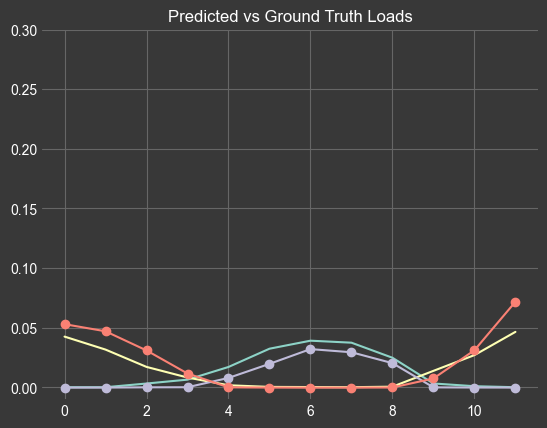

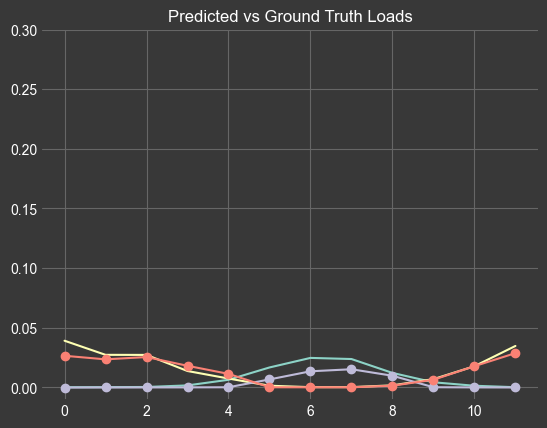

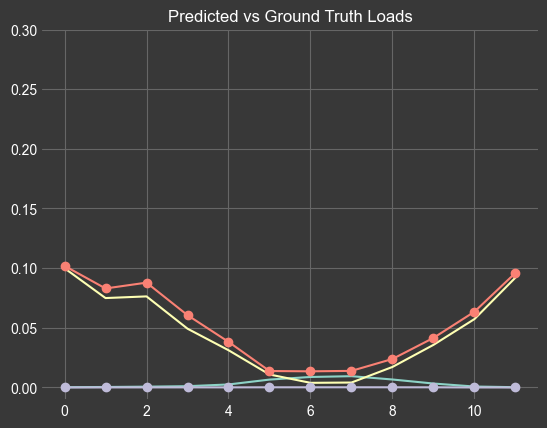

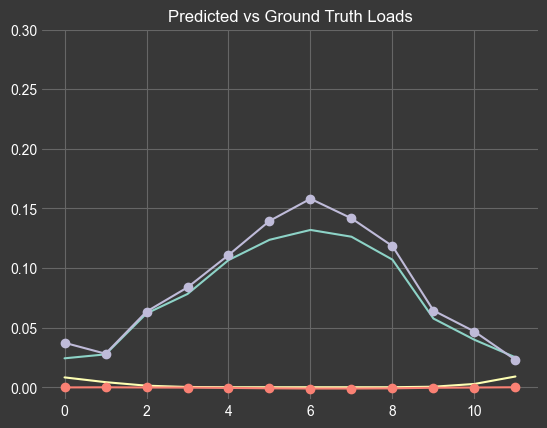

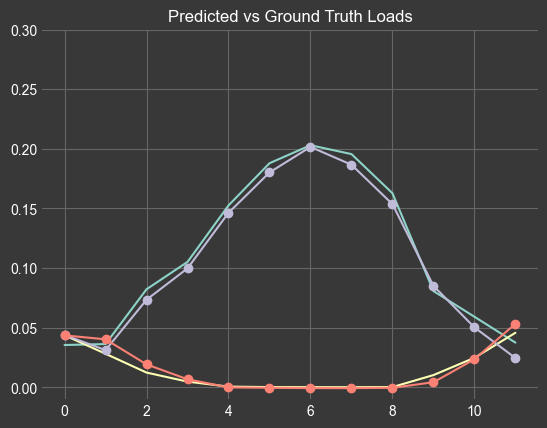

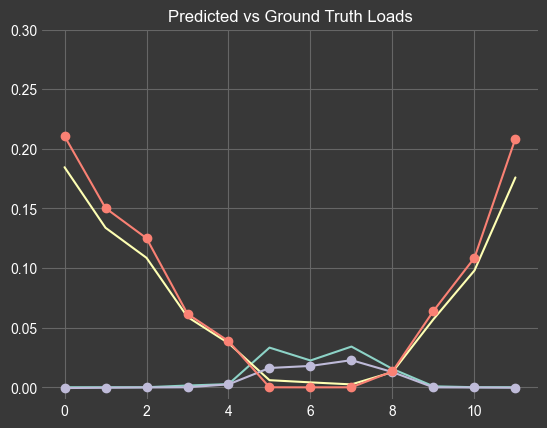

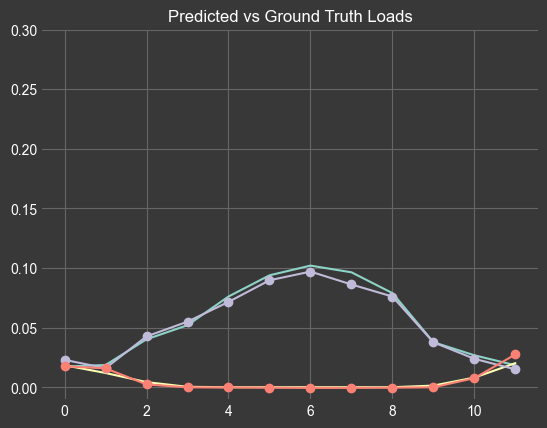

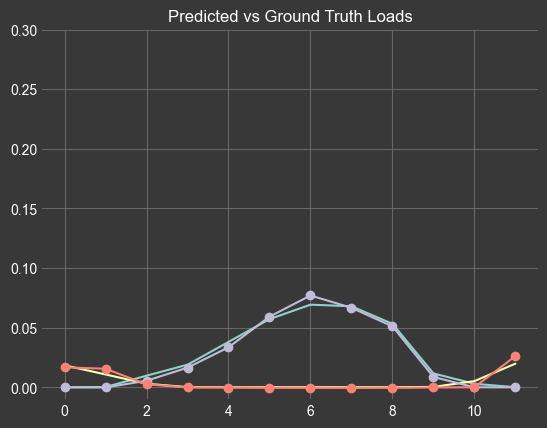

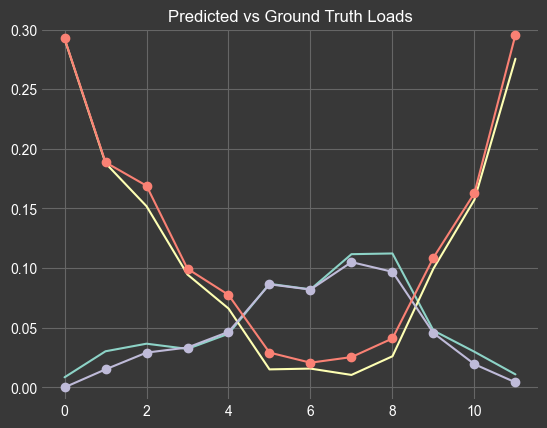

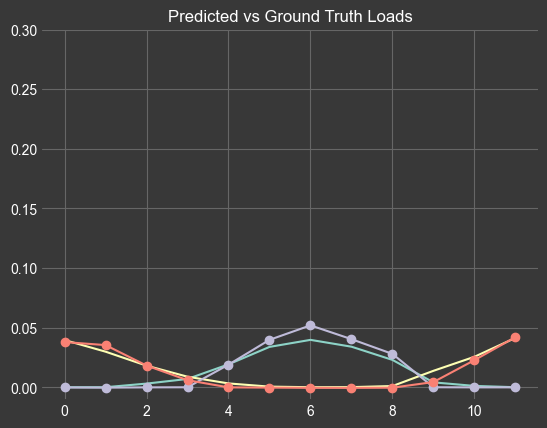

In [48]:
# i = 200
# fig, axs = plt.subplots(5,4)
np.random.seed(5)
ix = np.random.choice(np.arange(all_loads.shape[0]), 20)
for idx in range(10):
    i = ix[idx]

    # fig, axs = plt.subplots(1,2, figsize=(15,5))
    fig = plt.figure()
    # ax = axs[0].twinx()
    # ax.plot(
    #     all_temps[i,:30*24*12].reshape(12,30*24).mean(axis=1).cpu(),
    #     label="Temp",
    # )
    plt.title("Predicted vs Ground Truth Loads")
    plt.plot(all_loads[i, 1, :].cpu(), label="Actual cooling")
    plt.plot(all_loads[i, 0, :].cpu(), label="Actual heating")
    plt.plot(all_results[i, 1, :].cpu(), "-o",label="Predicted cooling")
    plt.plot(all_results[i, 0, :].cpu(),"-o", label="Predicted heating")
    plt.ylim([-0.01,0.3])
    plt.show()

### Visualize Fit Over Unseen Data

In [40]:
for it in tqdm(range(120)):
    all_loads = []
    all_results = []
    losses = []
    epws = []
    czs = []
    temps = []
    data_to_plot = make_dataset(start_idx=400000+it*1000, count=1000, loader_batch_size=100)
    test_dataloader = data_to_plot["dataloaders"]["test"] # fine to use training since it's never been seen
    with torch.no_grad():
        for test_samples in test_dataloader:
            # test_samples = next(iter(test_dataloader))
            timeseries = test_samples["timeseries_vector"].to(device).float()
            bldg_vect = test_samples["building_vector"].to(device).float()
            loads = test_samples["results_vector"].to(device).float()
            timeseries_latvect = timeseries_model(timeseries)

            # Concatenate vectors
            x = torch.cat([timeseries_latvect, bldg_vect], axis=1)
            x = x.squeeze(1)

            predicted_loads = energy_model(x)
            all_loads.append(loads)
            all_results.append(predicted_loads)


    all_loads = torch.vstack(all_loads)
    all_results = torch.vstack(all_results)
    # all_losses = torch.vstack(losses)


    n_rows = 4
    n_cols = 4
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(15,10))
    ix = np.random.choice(np.arange(all_loads.shape[0]), n_rows*n_cols)
    for idx_x in range(n_cols):
        for idx_y in range(n_rows):
            i = ix[idx_x*n_cols+idx_y]
            axs[idx_x, idx_y].plot(all_loads[i, 1, :].cpu(), label="Actual cooling")
            axs[idx_x, idx_y].plot(all_loads[i, 0, :].cpu(), label="Actual heating")
            axs[idx_x, idx_y].plot(all_results[i, 1, :].cpu(), "-o", label="Predicted cooling")
            axs[idx_x, idx_y].plot(all_results[i, 0, :].cpu(), "-o", label="Predicted heating")
            axs[idx_x, idx_y].set_ylim([-0.01,0.4])
            if idx_x == 0 and idx_y == 0:
                axs[idx_x,idx_y].legend()
                axs[idx_x,idx_y].set_title("Predcited vs True Loads")
            # ax = plt.gca().twinx()
            # ax.plot(
            #     all_temps[i].cpu(),
            #     label="Temp",
            # )
            # plt.legend()
    fig.tight_layout()
    fig.savefig(f"./images/labels_fixed_{it:05d}.png")
    plt.close()

  0%|          | 0/120 [00:00<?, ?it/s]

Calculating mean from batch data for orientation...
Calculating mean from batch data for orientation...
Calculating mean from batch data for orientation...
Calculating mean from batch data for orientation...
Calculating mean from batch data for orientation...
Calculating mean from batch data for orientation...
Calculating mean from batch data for orientation...
Calculating mean from batch data for orientation...
Calculating mean from batch data for orientation...
Calculating mean from batch data for orientation...
Calculating mean from batch data for orientation...
Calculating mean from batch data for orientation...
Calculating mean from batch data for orientation...
Calculating mean from batch data for orientation...
Calculating mean from batch data for orientation...
Calculating mean from batch data for orientation...
Calculating mean from batch data for orientation...
Calculating mean from batch data for orientation...
Calculating mean from batch data for orientation...
Calculating 

## Computing Total Error Etc

In [51]:

all_loads = []
all_results = []
for it in tqdm(range(120)):
    print(f"It {it}")
    losses = []
    epws = []
    czs = []
    temps = []
    data_to_plot = make_dataset(start_idx=400000+it*1000, count=1000, loader_batch_size=100)
    test_dataloader = data_to_plot["dataloaders"]["test"] # fine to use training since it's never been seen
    with torch.no_grad():
        for test_samples in test_dataloader:
            # test_samples = next(iter(test_dataloader))
            timeseries = test_samples["timeseries_vector"].to(device).float()
            bldg_vect = test_samples["building_vector"].to(device).float()
            loads = test_samples["results_vector"].to(device).float()
            timeseries_latvect = timeseries_model(timeseries)

            # Concatenate vectors
            x = torch.cat([timeseries_latvect, bldg_vect], axis=1)
            x = x.squeeze(1)

            predicted_loads = energy_model(x)
            all_loads.append(loads)
            all_results.append(predicted_loads)


all_loads = torch.vstack(all_loads)
all_results = torch.vstack(all_results)
print(all_loads.shape)
print(all_results.shape)



  0%|          | 0/120 [00:00<?, ?it/s]

It 0
Calculating mean from batch data for orientation...
It 1
Calculating mean from batch data for orientation...
It 2
Calculating mean from batch data for orientation...
It 3
Calculating mean from batch data for orientation...
It 4
Calculating mean from batch data for orientation...
It 5
Calculating mean from batch data for orientation...
It 6
Calculating mean from batch data for orientation...
It 7
Calculating mean from batch data for orientation...
It 8
Calculating mean from batch data for orientation...
It 9
Calculating mean from batch data for orientation...
It 10
Calculating mean from batch data for orientation...
It 11
Calculating mean from batch data for orientation...
It 12
Calculating mean from batch data for orientation...
It 13
Calculating mean from batch data for orientation...
It 14
Calculating mean from batch data for orientation...
It 15
Calculating mean from batch data for orientation...
It 16
Calculating mean from batch data for orientation...
It 17
Calculating mean f

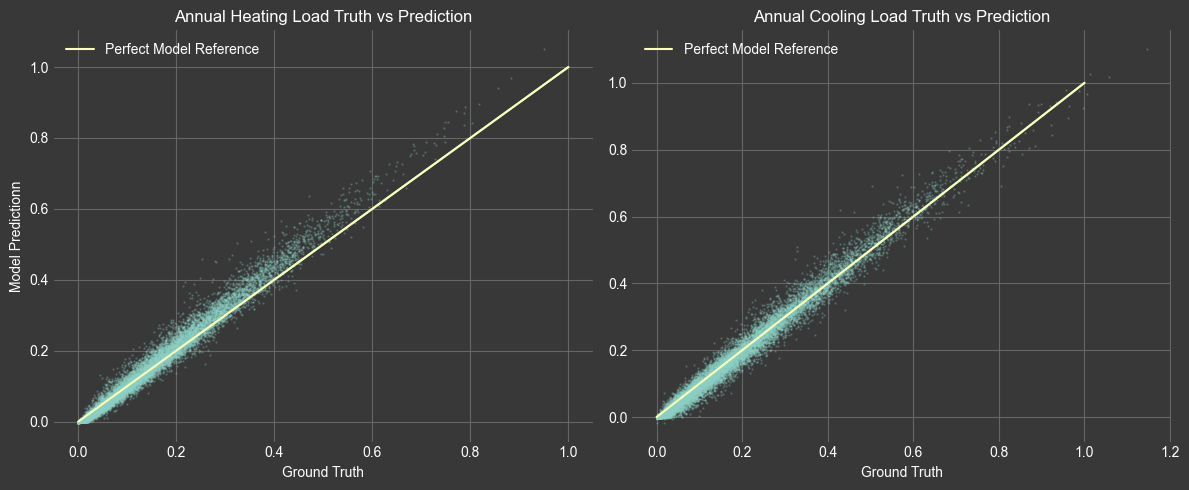

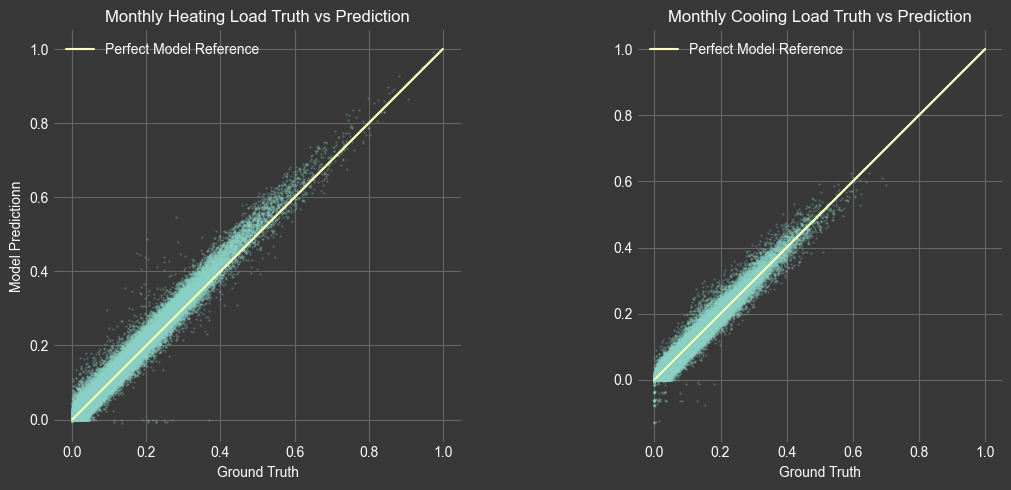

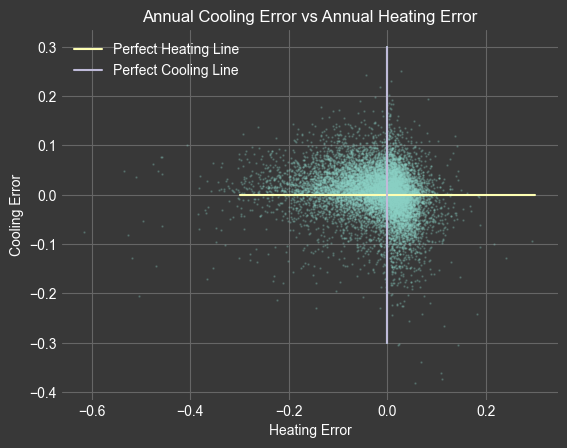

In [79]:
heating_true = torch.sum(all_loads[:,0],axis=1)
cooling_true = torch.sum(all_loads[:,1],axis=1)
heating_pred = torch.sum(all_results[:,0],axis=1)
cooling_pred = torch.sum(all_results[:,1],axis=1)

t = np.linspace(0,1,100)
fig, axs = plt.subplots(1,2, figsize=(12,5))
axs[0].set_title("Annual Heating Load Truth vs Prediction")
axs[0].scatter(heating_true.cpu()/3,heating_pred.cpu()/3, s=0.5, alpha=0.25)
axs[0].plot(t,t)
axs[0].plot(t,t, label="Perfect Model Reference")
axs[0].legend()
axs[1].set_title("Annual Cooling Load Truth vs Prediction")
axs[1].scatter(cooling_true.cpu()/2,cooling_pred.cpu()/2, s=0.5, alpha=0.25)
axs[1].plot(t,t)
axs[1].plot(t,t, label="Perfect Model Reference")
axs[1].legend()
axs[0].set_ylabel("Model Predictionn")
axs[0].set_xlabel("Ground Truth")
axs[1].set_xlabel("Ground Truth")
fig.tight_layout()

t = np.linspace(0,1,100)
fig, axs = plt.subplots(1,2, figsize=(12,5))
axs[0].set_title("Monthly Heating Load Truth vs Prediction")
axs[0].scatter(all_loads[:,0,:].flatten().cpu()*2, all_results[:,0,:].flatten().cpu()*2, s=0.5, alpha=0.25)
axs[0].plot(t,t)
axs[0].plot(t,t, label="Perfect Model Reference")
axs[0].set_aspect("equal")
axs[0].legend()
axs[1].set_title("Monthly Cooling Load Truth vs Prediction")
axs[1].scatter(all_loads[:,1,:].flatten().cpu()*2, all_results[:,1,:].flatten().cpu()*2, s=0.5, alpha=0.25)
axs[1].plot(t,t)
axs[1].plot(t,t, label="Perfect Model Reference")
axs[1].legend()
axs[1].set_aspect("equal")
axs[0].set_ylabel("Model Predictionn")
axs[0].set_xlabel("Ground Truth")
axs[1].set_xlabel("Ground Truth")
fig.tight_layout()

plt.figure()
plt.title("Annual Cooling Error vs Annual Heating Error")
plt.scatter((heating_true-heating_pred).cpu(), (cooling_true-cooling_pred).cpu(), s=0.5, alpha=0.25)
t = np.linspace(-0.3,0.3,100)
plt.plot(0*t,t)
plt.plot(t,0*t, label="Perfect Heating Line")
plt.plot(0*t,t, label="Perfect Cooling Line")
plt.xlabel("Heating Error")
plt.ylabel("Cooling Error")
plt.legend()

In [ ]:

#     'width', 
#     'height', 
#     'facade_2_footprint', 
#     'perim_2_footprint',
#     'roof_2_footprint',
#     'footprint_2_ground',
#     'wwr',
#     'orientation',
#     'HeatingSetpoint',
#     'CoolingSetpoint',
#     'LightingPowerDensity',
#     'EquipmentPowerDensity',
#     'PeopleDensity',
#     'Infiltration',
#     'FacadeMass',
#     'RoofMass',
#     'FacadeRValue',
#     'RoofRValue',
#     'SlabRValue',
#     ]

# building_vector_size = len(building_vect_schema) + 3 # (area/windowsettings)


### Design Space Exploration

In [79]:

building_vector_sample, timeseries_vector_sample, _norm_results = load_training_samples(schema, start_idx=70000, count=2000)
# building_vector_sample[:,7] = 0 # fix orientation

Calculating mean from batch data for orientation...


In [80]:
source_vec = 1

building_vector = building_vector_sample[source_vec:source_vec+1]
timeseries_vector = timeseries_vector_sample[source_vec:source_vec+1]
max_its = 4000
building_vector = np.array([building_vector[0]]*12).T
building_vector = building_vector.reshape(-1,*building_vector.shape)
building_vector = building_vector.repeat(max_its , axis=0)
t = np.linspace(0,2*np.pi,max_its ).reshape(-1,1).repeat(12, axis=1)
building_vector[:,6] = 0.25 + 0.75*(np.cos(2.2*t-np.pi)+1)/2 #wwr
building_vector[:,8] = 0.05 + 0.7*(np.cos(4.2*t-np.pi)+1)/2 #hsp
building_vector[:,9] = 0.3 + 0.4*(np.cos(5.5*t-np.pi)+1)/2 #csp
building_vector[:,13] = 0.05 + 0.5*(np.cos(3.7*t-np.pi)+1)/2 # inf
building_vector[:,16] = 0.05 + 0.5*(np.cos(8.1*4*t-np.pi)+1)/2 # fr
building_vector[:,17] = 0.05 + 0.5*(np.cos(3.4*4*t-np.pi)+1)/2 # rfr

timeseries_vector = timeseries_vector.repeat(max_its , axis=0)

torch.cuda.empty_cache()
results = []
latent = []
with torch.no_grad():
    for i in range(0,max_its ,100):
        timeseries = torch.Tensor(timeseries_vector[i:i+100]).to(device)
        building = torch.Tensor(building_vector[i:i+100]).to(device)
        timeseries_latvect = timeseries_model(timeseries)
        latent.append(timeseries_latvect)
        x = torch.cat([timeseries_latvect, building], axis=1)
        x = x.squeeze(1)
        predicted_loads = energy_model(x)
        results.append(predicted_loads)
results = torch.vstack(results)
latent = torch.vstack(latent)
print(torch.max(results[:,0]))
print(torch.max(results[:,1]))

if False:
    for it in range(0,max_its,1):
        fig, axs = plt.subplots(1,2, figsize=(20,5))
        axs[0].set_title("Predicted Loads")
        axs[0].plot(results[it,1].cpu(), "-o", label="Predicted Cooling")
        axs[0].plot(results[it,0].cpu(), "-o", label="Predicted Heating")
        axs[0].legend()
        axs[1].bar(["WWR", "H. SP", "C. SP", "Inf.", "Facade R", "Roof R"], building_vector[it,[6,8,9,13,16,17],0])
        axs[0].set_ylim([-0.01,0.45])
        axs[1].set_ylim([0,1.0])
        axs[1].set_title("Normalized Parameters")
        fig.savefig(f"./images/dse_{it:05d}.png")
        plt.close()

tensor(0.4395, device='cuda:0')
tensor(0.1892, device='cuda:0')


# Visualizations
- Latent space - T-sne
- 

In [74]:
print(schema)

-------- Schema --------
---- batch_id ----
shape storage: (1,) / shape ml: (0,)
location storage: 0->1 / location ml: 0->0

---- variation_id ----
shape storage: (1,) / shape ml: (0,)
location storage: 1->2 / location ml: 0->0

---- program_type ----
shape storage: (1,) / shape ml: (19,)
location storage: 2->3 / location ml: 0->19

---- vintage ----
shape storage: (1,) / shape ml: (1,)
location storage: 3->4 / location ml: 19->20

---- climate_zone ----
shape storage: (1,) / shape ml: (17,)
location storage: 4->5 / location ml: 20->37

---- base_epw ----
shape storage: (1,) / shape ml: (0,)
location storage: 5->6 / location ml: 37->37

---- width ----
shape storage: (1,) / shape ml: (1,)
location storage: 6->7 / location ml: 37->38

---- height ----
shape storage: (1,) / shape ml: (1,)
location storage: 7->8 / location ml: 38->39

---- facade_2_footprint ----
shape storage: (1,) / shape ml: (1,)
location storage: 8->9 / location ml: 39->40

---- perim_2_footprint ----
shape storage: (

In [113]:
train_test_split_idx = 400000
with h5py.File("./data/hdf5/all_data_monthly.hdf5", "r") as f:
    unseen_batch = f["storage_batch"][train_test_split_idx:]
    seen_batch = f["storage_batch"][:train_test_split_idx]
    seen_areas = f["area"][:train_test_split_idx]
    unseen_areas = f["area"][train_test_split_idx:]

train_test_split_idx = 400000
with h5py.File("./data/hdf5/all_data_monthly.hdf5", "r") as f:
    epw = f["storage_batch"][train_test_split_idx:, 5]
    cz = f["storage_batch"][train_test_split_idx:, 4]

with h5py.File("./data/hdf5/all_data_monthly.hdf5", "r") as f:
    epw_seen = f["storage_batch"][:train_test_split_idx, 5]
    cz_seen = f["storage_batch"][:train_test_split_idx:, 4]

50294


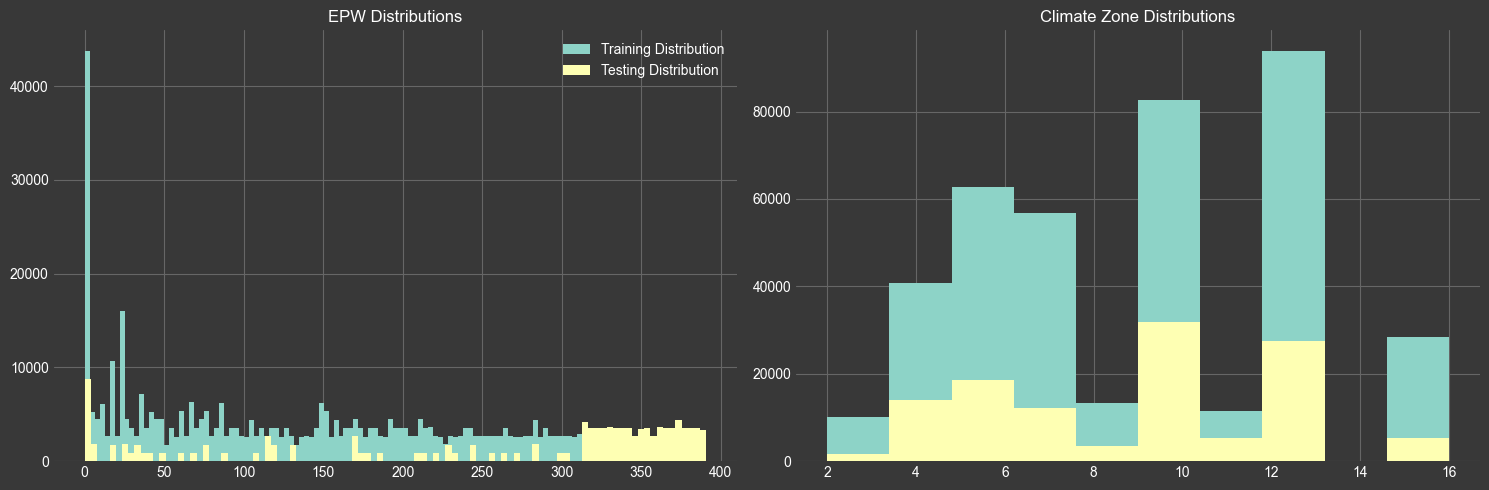

In [73]:
fig, axs = plt.subplots(1,2,figsize=(15,5))
axs[0].hist(epw_seen, bins=100, label="Training Distribution")
axs[0].hist(epw, bins=100, label="Testing Distribution")
axs[0].legend()
axs[0].set_title("EPW Distributions")
axs[1].hist(cz_seen,  label="Training Distribution")
axs[1].hist(cz,  label="Testing Distribution")
axs[1].set_title("Climate Zone Distributions")
fig.tight_layout()
fig.savefig("./figures/climate_distros.png")

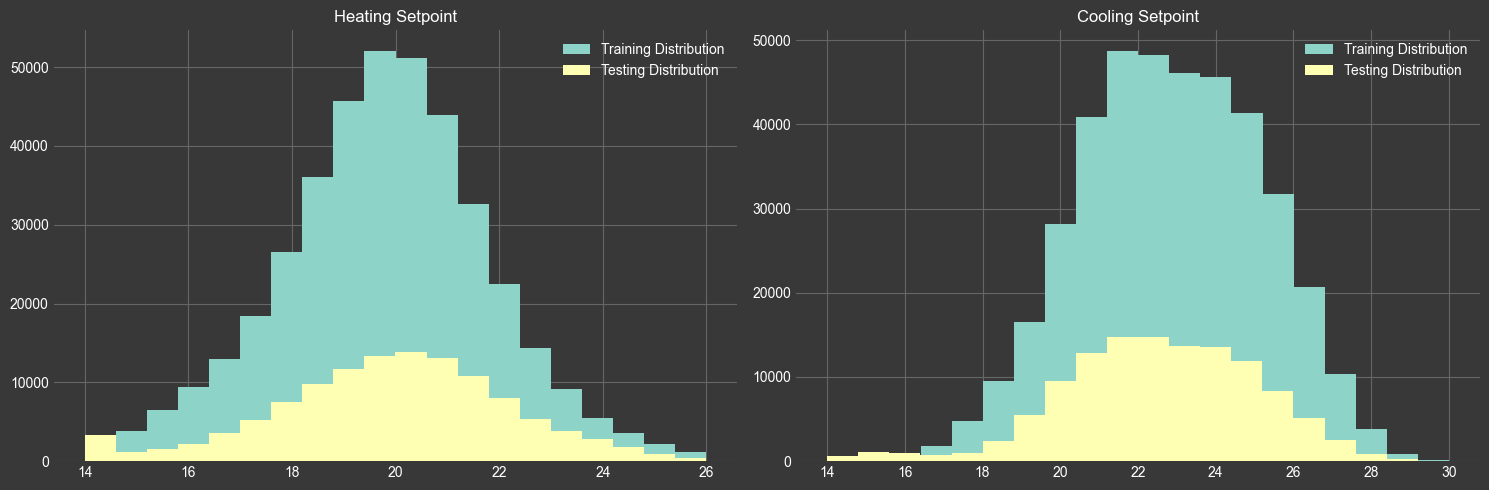

In [75]:
title = "setpoint_distros"
left_param, left_title =  "HeatingSetpoint", "Heating Setpoint"
right_param, right_title ="CoolingSetpoint", "Cooling Setpoint"
l_values = schema[left_param].extract_storage_values_batch(unseen_batch)
l_values_seen = schema[left_param].extract_storage_values_batch(seen_batch)
r_values = schema[right_param].extract_storage_values_batch(unseen_batch)
r_values_seen = schema[right_param].extract_storage_values_batch(seen_batch)

# w_values = schema["width"].extract_storage_values_batch(unseen_batch)
# w_values_seen = schema["width"].extract_storage_values_batch(seen_batch)
# h_values = schema["height"].extract_storage_values_batch(unseen_batch)
# h_values_seen = schema["height"].extract_storage_values_batch(seen_batch)
# f_values = schema["facade_2_footprint"].extract_storage_values_batch(unseen_batch)
# f_values_seen = schema["facade_2_footprint"].extract_storage_values_batch(seen_batch)

# r_values = w_values * (h_values / f_values)
# r_values_seen = w_values_seen * (h_values_seen / f_values_seen)



fig, axs = plt.subplots(1,2,figsize=(15,5))
axs[0].hist(l_values_seen, bins=20, label="Training Distribution")
axs[0].hist(l_values, bins=20,label="Testing Distribution")
axs[0].legend()
axs[0].set_title(left_title)
axs[1].hist(r_values_seen,  bins=20, label="Training Distribution")
axs[1].hist(r_values,  bins=20, label="Testing Distribution")
axs[1].set_title(right_title)
axs[1].legend()
fig.tight_layout()
fig.savefig(f"./figures/{title}.png")

Calculating mean from batch data for orientation...
90.46 5.6
Calculating mean from batch data for orientation...
90.63 6.59


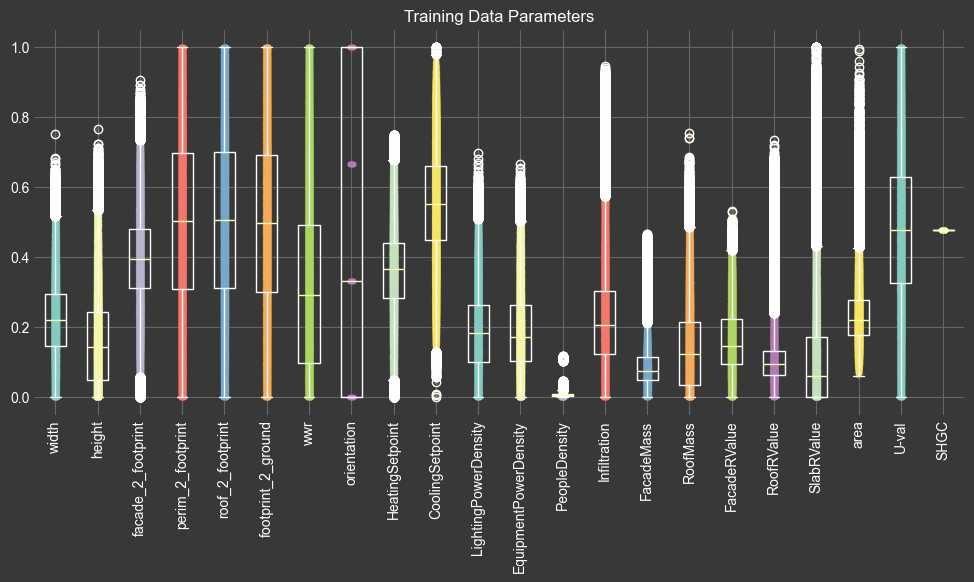

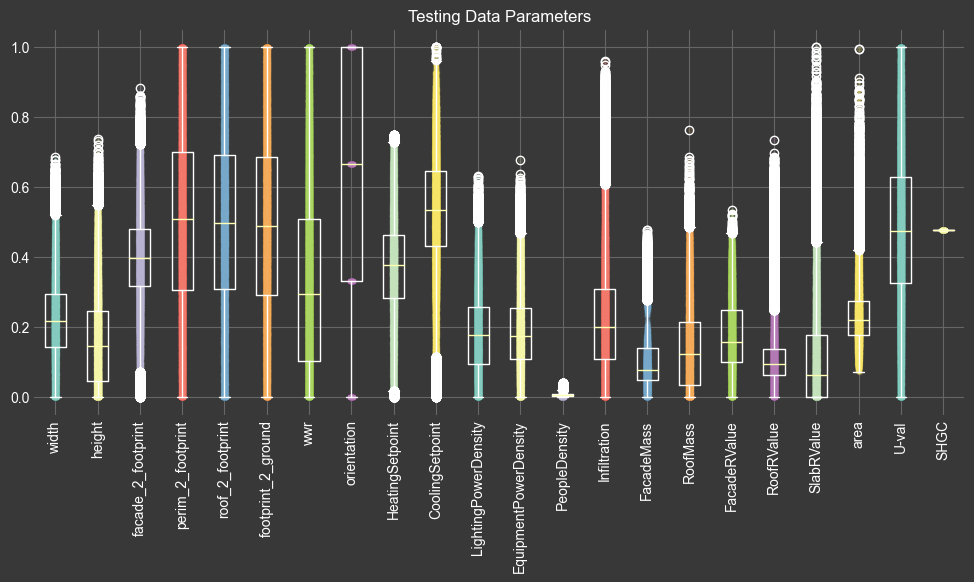

In [119]:

def make_bldg_vector(batch, areas, amax=91, amin=0):
    building_vector = np.zeros((batch.shape[0], 22))
    for i, schema_name in enumerate(building_vect_schema):
        column = schema[schema_name].extract_storage_values_batch(batch).flatten()
        try:
            column = normalize(column, schema[schema_name].max, schema[schema_name].min)
        except:
            print(f"Calculating mean from batch data for {schema_name}...")
            column = normalize(column, np.max(column), np.min(column))
        building_vector[:, i] = column
    wind_settings = schema["WindowSettings"].extract_storage_values_batch(batch)
    print(np.max(areas), np.min(areas))
    building_vector[:, -3] = normalize(areas, amax, amin)
    building_vector[:, -2] = normalize(wind_settings[:, 0].flatten(), schema["WindowSettings"].max[0], schema["WindowSettings"].min[0]) # U-val
    building_vector[:, -1] = normalize(wind_settings[:, 1].flatten(), schema["WindowSettings"].max[1], schema["WindowSettings"].min[1]) # shgc
    return building_vector

building_vector_seen = make_bldg_vector(seen_batch, seen_areas)
building_vector_unseen = make_bldg_vector(unseen_batch, unseen_areas)

def make_box_whisker(building_vector, title, prefix=""):
    fig = plt.figure(figsize=(12,5))
    for c in range(len(building_vect_schema) + 3):
        y = building_vector[:, c]
        # Add some random "jitter" to the x-axis
        x = np.random.normal(c, 0.01, size=len(y))
        plt.plot(x+1, y, '.', alpha=0.1)
    plt.boxplot(building_vector)
    plt.xticks(ticks = list(range(1, 23)), labels=building_vect_schema + ["area", "U-val", "SHGC"], rotation = 90)
    plt.title(title)
    plt.show()
    fig.savefig(f"./figures/{prefix}-box-whisker.png")

make_box_whisker(building_vector_seen, "Training Data Parameters", "seen")
make_box_whisker(building_vector_unseen, "Testing Data Parameters", "unseen")